# Reinforcement Learning: Zero to Hero - Part 9/17

**Cells 161-166 of 291**



#### Visualizing Training Progress

Let's visualize how the agent's performance improved during training:

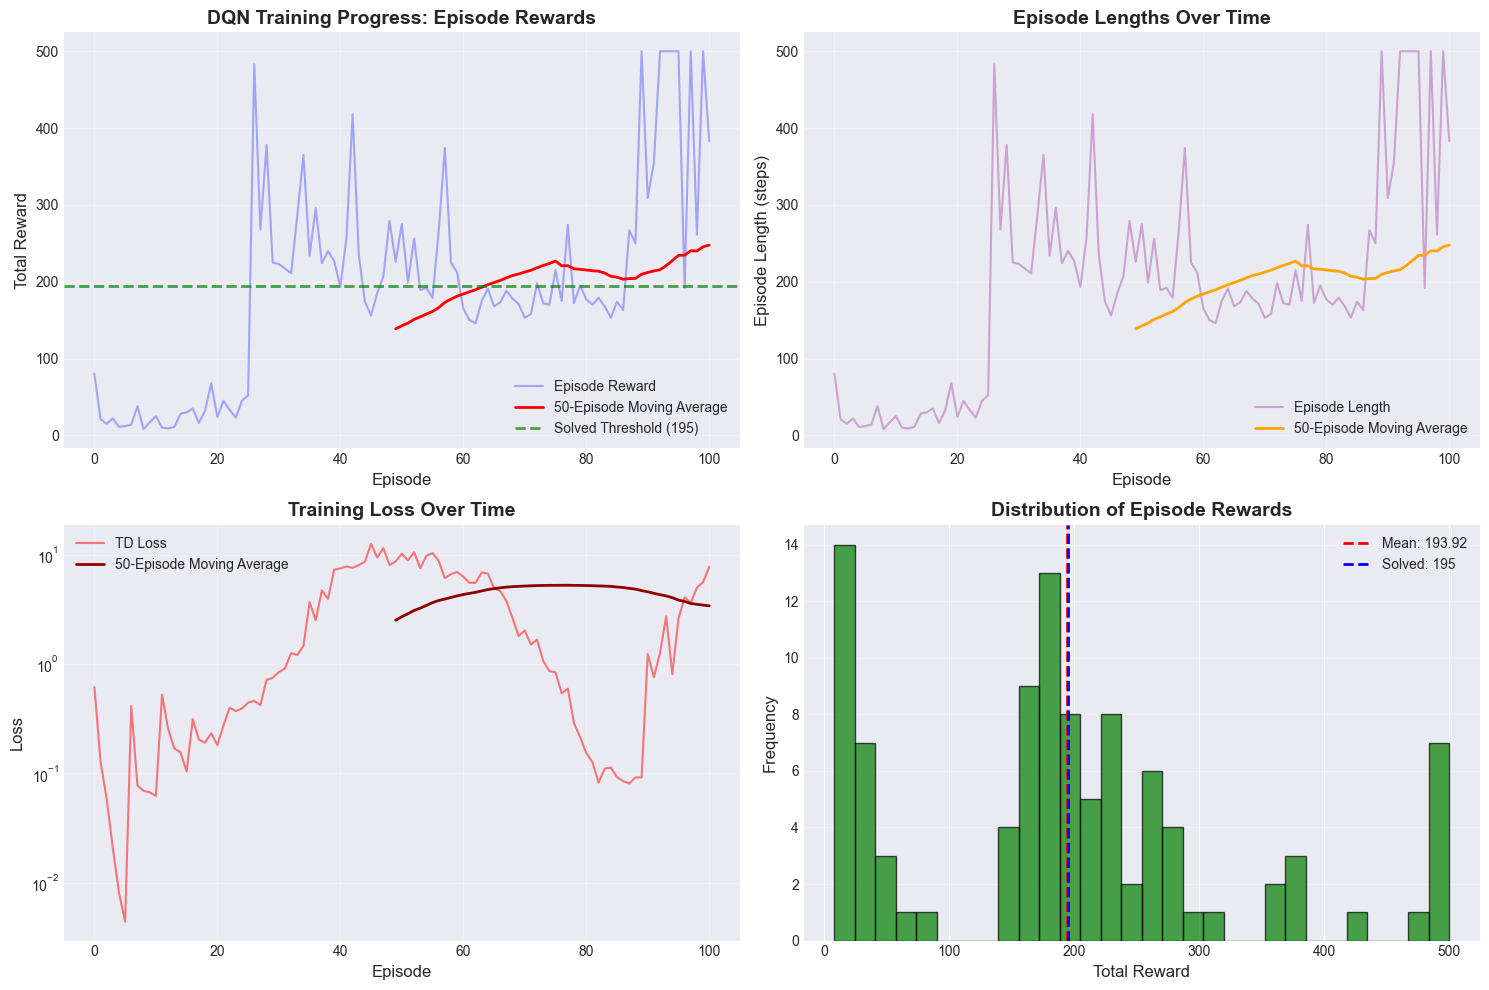

📊 Training Summary Statistics:
Total Episodes: 101
Reward Statistics:
  Mean: 193.92
  Std: 133.07
  Min: 8.00
  Max: 500.00
  Last 100 episodes mean: 195.06
Episode Length Statistics:
  Mean: 193.92
  Max: 500
Exploration:
  Final epsilon: 0.0100
  Replay buffer size: 10000
✅ Environment SOLVED! Average reward ≥ 195 over last 100 episodes


In [89]:
# Create comprehensive training visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Episode Rewards
ax1 = axes[0, 0]
ax1.plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
# Moving average
window = 50
if len(rewards) >= window:
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(rewards)), moving_avg, color='red', 
             linewidth=2, label=f'{window}-Episode Moving Average')
ax1.axhline(y=195, color='green', linestyle='--', linewidth=2, 
            label='Solved Threshold (195)', alpha=0.7)
ax1.set_xlabel('Episode', fontsize=12)
ax1.set_ylabel('Total Reward', fontsize=12)
ax1.set_title('DQN Training Progress: Episode Rewards', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Episode Lengths
ax2 = axes[0, 1]
ax2.plot(lengths, alpha=0.3, color='purple', label='Episode Length')
if len(lengths) >= window:
    moving_avg_length = np.convolve(lengths, np.ones(window)/window, mode='valid')
    ax2.plot(range(window-1, len(lengths)), moving_avg_length, color='orange', 
             linewidth=2, label=f'{window}-Episode Moving Average')
ax2.set_xlabel('Episode', fontsize=12)
ax2.set_ylabel('Episode Length (steps)', fontsize=12)
ax2.set_title('Episode Lengths Over Time', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Training Loss
ax3 = axes[1, 0]
if losses:
    ax3.plot(losses, alpha=0.5, color='red', label='TD Loss')
    if len(losses) >= window:
        moving_avg_loss = np.convolve(losses, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(losses)), moving_avg_loss, color='darkred', 
                 linewidth=2, label=f'{window}-Episode Moving Average')
    ax3.set_xlabel('Episode', fontsize=12)
    ax3.set_ylabel('Loss', fontsize=12)
    ax3.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')  # Log scale for better visualization
else:
    ax3.text(0.5, 0.5, 'No loss data available', 
             ha='center', va='center', fontsize=12)
    ax3.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')

# Plot 4: Reward Distribution
ax4 = axes[1, 1]
ax4.hist(rewards, bins=30, alpha=0.7, color='green', edgecolor='black')
ax4.axvline(x=np.mean(rewards), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(rewards):.2f}')
ax4.axvline(x=195, color='blue', linestyle='--', 
            linewidth=2, label='Solved: 195')
ax4.set_xlabel('Total Reward', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Episode Rewards', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("📊 Training Summary Statistics:")
print("="*60)
print(f"Total Episodes: {len(rewards)}")
print(f"Reward Statistics:")
print(f"  Mean: {np.mean(rewards):.2f}")
print(f"  Std: {np.std(rewards):.2f}")
print(f"  Min: {np.min(rewards):.2f}")
print(f"  Max: {np.max(rewards):.2f}")
print(f"  Last 100 episodes mean: {np.mean(rewards[-100:]):.2f}")
print(f"Episode Length Statistics:")
print(f"  Mean: {np.mean(lengths):.2f}")
print(f"  Max: {np.max(lengths)}")
print(f"Exploration:")
print(f"  Final epsilon: {agent.epsilon:.4f}")
print(f"  Replay buffer size: {len(agent.replay_buffer)}")

if np.mean(rewards[-100:]) >= 195:
    print("✅ Environment SOLVED! Average reward ≥ 195 over last 100 episodes")
else:
    print(f"⚠️  Not quite solved yet. Need {195 - np.mean(rewards[-100:]):.2f} more reward on average.")

#### Understanding the Results

**What We Observe:**

1. **Learning Curve**: The agent starts with poor performance (random actions) and gradually improves as it learns

2. **Exploration vs Exploitation**: 
   - Early episodes: High epsilon → more exploration → variable performance
   - Later episodes: Low epsilon → more exploitation → stable high performance

3. **Target Network Impact**:
   - Training is stable without wild oscillations
   - Loss decreases smoothly over time
   - The agent converges to a good policy

4. **Experience Replay Benefits**:
   - Efficient use of past experiences
   - Breaks temporal correlations
   - Enables mini-batch training

**Key Insights:**

- **Target networks** prevent the moving target problem and stabilize training
- **Experience replay** breaks correlations and improves sample efficiency
- **Epsilon-greedy** exploration ensures the agent discovers good strategies
- The combination of these techniques makes DQN work!

**Hyperparameter Sensitivity:**

- **Learning rate**: Too high → instability; too low → slow learning
- **Target update frequency**: Too frequent → moving target; too rare → slow adaptation
- **Batch size**: Larger → more stable gradients; smaller → more updates
- **Buffer size**: Larger → more diversity; smaller → more recent experiences

**Next Steps:**

DQN with target networks is a powerful algorithm, but it still has limitations. In the next section, we'll explore **Double DQN**, which addresses the overestimation bias in standard DQN!

#### Double DQN: Addressing Overestimation Bias

**The Problem with Standard DQN**

Standard DQN has a subtle but important flaw: it tends to **overestimate** Q-values. This happens because of how the max operator is used in the Q-learning update:

$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s,a) \right]
$

**Why Overestimation Occurs:**

The same network is used for both:
1. **Selecting** the best action: $\arg\max_{a'} Q(s', a')$
2. **Evaluating** that action: $Q(s', a')$

This creates a **maximization bias**: if the Q-values have any estimation errors (which they always do), the max operation will tend to select actions with positive errors, leading to systematic overestimation.

**Example of the Problem:**

Imagine you're estimating the value of 3 actions, and your estimates have random errors:
- True values: [1.0, 1.0, 1.0] (all equal)
- Noisy estimates: [0.9, 1.2, 0.8] (with random errors)
- Standard DQN picks: max([0.9, 1.2, 0.8]) = 1.2
- This overestimates the true value of 1.0!

Over many updates, these overestimations accumulate and can hurt performance.

**The Double DQN Solution**

Double DQN (DDQN) addresses this by **decoupling action selection from action evaluation**:

1. Use the **online network** to select the best action
2. Use the **target network** to evaluate that action

**Double DQN Update Rule:**

$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma Q_{\theta^-}\left(s', \arg\max_{a'} Q_\theta(s', a')\right) - Q(s,a) \right]
$

where:
- $Q_\theta$ is the online network (selects action)
- $Q_{\theta^-}$ is the target network (evaluates action)

**Key Insight:**

By using different networks for selection and evaluation, we reduce the correlation between the errors, which reduces overestimation bias.

**Benefits of Double DQN:**

- More accurate Q-value estimates
- Better performance on many tasks
- More stable learning
- Minimal computational overhead (we already have both networks!)

Let's implement Double DQN and compare it with standard DQN!

In [90]:
class DoubleDQNAgent(DQNAgent):
    """Double DQN agent that reduces overestimation bias.
    
    Inherits from DQNAgent and only modifies the update method to use
    Double Q-learning: online network selects actions, target network evaluates them.
    """
    
    def update(self):
        """Update the agent using Double Q-learning.
        
        Key difference from standard DQN:
        - Online network selects the best action
        - Target network evaluates that action
        """
        # Need enough samples in buffer
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample mini-batch from replay buffer
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert to tensors
        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones)
        
        # Compute current Q-values
        current_q_values = self.online_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute target Q-values using Double Q-learning
        with torch.no_grad():
            # DOUBLE DQN: Use online network to SELECT actions
            next_actions = self.online_network(next_states).argmax(1)
            
            # DOUBLE DQN: Use target network to EVALUATE those actions
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            
            # Compute targets
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        # Compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        # Optimize the online network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network periodically
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.update_target_network()
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        
        return loss.item()


print("Double DQN Agent implemented!")
print("Key difference from standard DQN:")
print("  ✓ Online network SELECTS the best action")
print("  ✓ Target network EVALUATES that action")
print("  ✓ This decoupling reduces overestimation bias")

Double DQN Agent implemented!
Key difference from standard DQN:
  ✓ Online network SELECTS the best action
  ✓ Target network EVALUATES that action
  ✓ This decoupling reduces overestimation bias


#### Comparing Standard DQN vs Double DQN

Now let's train both algorithms on the same environment and compare their performance. We'll look at:

1. **Learning curves**: How quickly do they learn?
2. **Final performance**: Which achieves better results?
3. **Stability**: Which is more consistent?
4. **Q-value estimates**: Do we see evidence of overestimation?

Let's run the comparison: